# 01 — EDA · Film Greenlight Recommender

**Objetivo** — Examinar a base cinematográfica para entender estrutura, qualidade
dos dados e padrões iniciais, gerando hipóteses para etapas posteriores.

**Entradas** — `data/raw/imdb.csv`  
**Saídas** — Visualizações e tabelas no notebook; lista de ações para
pré-processamento.

**Escopo**  
- Saúde do dado: dimensões, tipos, duplicatas, **missing rate**.  
- Conversões **somente para análise** (`Runtime_min`, `Gross_usd`, `Decade`).  
- Univariado: distribuições e outliers (log para caudas longas).  
- Categóricas: gêneros, certificados, diretores e elenco.  
- Temporais: evolução por década e tendências históricas.  
- Multivariado: correlações entre métricas e interações categoria × nota/faturamento.  
- Overview: análise rápida (faltantes, comprimento, vocabulário mais frequente).  
- Achados e próximos passos para o pipeline.  

Autora: *Ana Luiza Gomes Vieira* · Execução: *Set/2025*

## Setup

In [ ]:
# Bibliotecas padrão
import re
import warnings
from collections import Counter
from pathlib import Path

# Bibliotecas de terceiros
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [ ]:
# Configurações globais
SEED = 42
PROJECT_ROOT = Path.cwd().parent
DATA_RAW = PROJECT_ROOT / "data" / "raw" / "imdb.csv"

assert DATA_RAW.exists(), f"Arquivo não encontrado: {DATA_RAW}"

In [ ]:
# Configurações de exibição
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

# Estilo de gráficos
sns.set_theme()
warnings.filterwarnings("ignore")

## 1. Carregamento e visão geral dos dados

- Importação do dataset bruto localizado em `data/raw/imdb.csv`;
- Verificação das dimensões (linhas e colunas);
- Visualização de uma amostra inicial;
- Análise preliminar de tipos de dados, valores ausentes e duplicatas.

### 1.1 Estrutura inicial

In [4]:
df_raw = pd.read_csv(DATA_RAW)
df = df_raw.copy()
df.shape

(999, 16)

In [5]:
df.head()

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


In [6]:
df.tail()

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
994,995,Breakfast at Tiffany's,1961,A,115 min,"Comedy, Drama, Romance",7.6,A young New York socialite becomes interested ...,76.0,Blake Edwards,Audrey Hepburn,George Peppard,Patricia Neal,Buddy Ebsen,166544,NaN
995,996,Giant,1956,G,201 min,"Drama, Western",7.6,Sprawling epic covering the life of a Texas ca...,84.0,George Stevens,Elizabeth Taylor,Rock Hudson,James Dean,Carroll Baker,34075,NaN
996,997,From Here to Eternity,1953,Passed,118 min,"Drama, Romance, War",7.6,"In Hawaii in 1941, a private is cruelly punish...",85.0,Fred Zinnemann,Burt Lancaster,Montgomery Clift,Deborah Kerr,Donna Reed,43374,"30,500,000"
997,998,Lifeboat,1944,NaN,97 min,"Drama, War",7.6,Several survivors of a torpedoed merchant ship...,78.0,Alfred Hitchcock,Tallulah Bankhead,John Hodiak,Walter Slezak,William Bendix,26471,NaN
998,999,The 39 Steps,1935,NaN,86 min,"Crime, Mystery, Thriller",7.6,A man in London tries to help a counter-espion...,93.0,Alfred Hitchcock,Robert Donat,Madeleine Carroll,Lucie Mannheim,Godfrey Tearle,51853,NaN


### 1.2 Qualidade dos dados

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


In [8]:
unique_counts = df.nunique().sort_values(ascending=False)
unique_counts

Unnamed: 0       999
Overview         999
Series_Title     998
No_of_Votes      998
Star4            938
Star3            890
Star2            840
Gross            822
Star1            659
Director         548
Genre            202
Runtime          140
Released_Year    100
Meta_score        63
IMDB_Rating       16
Certificate       16
dtype: int64

In [9]:
df["Series_Title"].value_counts()[df["Series_Title"].value_counts() > 1]

Series_Title
Drishyam    2
Name: count, dtype: int64

In [10]:
df.isna().sum()

Unnamed: 0         0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

In [11]:
na_n = df.isna().sum().rename("missing_n")
na_pct = df.isna().mean().mul(100).round(1).rename("missing_%")

out = pd.concat([na_n, na_pct], axis=1)
out = out[out["missing_n"] > 0].sort_values("missing_%", ascending=False)

if out.empty:
    print("Sem valores ausentes.")
else:
    display(out)

,missing_n,missing_%
Gross,169,16.9
Meta_score,157,15.7
Certificate,101,10.1


In [12]:
df.duplicated().sum()

np.int64(0)

#### Observações iniciais

- O dataset possui **999 registros** e **16 colunas**.  
- A coluna `Unnamed: 0` corresponde a um índice gerado no arquivo original e pode ser removida por não acrescentar informação.  
- Variáveis com **valores ausentes**:  
  - `Certificate`: 101 nulos (~10% do total).  
  - `Meta_score`: 157 nulos (~16%).  
  - `Gross`: 169 nulos (~17%).  
- Não há registros duplicados em nível de linha (`df.duplicated()` = 0).  
- Há **1 título duplicado em `Series_Title`** (`Drishyam`), que deve ser verificado em conjunto com `Released_Year`, `Director` e demais atributos para confirmar se se trata de duplicata ou versões distintas.  
- Tipagem:  
  - Algumas variáveis numéricas estão como `object` (ex.: `Released_Year`, `Runtime`, `Gross`) e precisarão de conversão.  
  - A coluna `Overview` contém texto livre, apropriada para análise de NLP.  
- Cardinalidade (valores distintos):  
  - Alta em colunas como `Series_Title` (998), `Overview` (999), `Star1–4` (entre 659 e 938), `Director` (548) → indicam dispersão elevada e pouca repetição.  
  - Média em `Genre` (202 combinações).  
  - Baixa em `Certificate` (16), `Released_Year` (100), `IMDB_Rating` (16) → possível uso como variáveis categóricas discretas.  
- `Released_Year` será tratado como **variável temporal**, de modo a evitar que o modelo interprete erroneamente anos mais recentes apenas como valores “maiores”. A ideia é derivar atributos como **idade do filme** ou **década de lançamento**.  
- Estrutura geral consistente: colunas de identificação (`Series_Title`, `Director`, `Stars`) bem definidas, além de métricas quantitativas de avaliação (`IMDB_Rating`, `Meta_score`, `No_of_Votes`, `Gross`).  

## 2. Análise Univariada

In [ ]:
#Conversões auxiliares para análise
df["Runtime_min"] = df["Runtime"].astype(str).str.extract(r"(\d+)")[0].astype(float)
df["Gross_usd"] = (
    df["Gross"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .replace("nan", np.nan)
    .astype(float)
)
df["Released_Year"] = pd.to_numeric(df["Released_Year"], errors="coerce")
df["Decade"] = (df["Released_Year"] // 10) * 10

### 2.1 Variáveis Numéricas
Avaliação da distribuição de variáveis contínuas (IMDB_Rating, Meta_score, No_of_Votes, Gross, Runtime).

In [14]:
df[["IMDB_Rating", "Meta_score", "No_of_Votes", "Gross", "Runtime"]].describe().T

,count,mean,std,min,25%,50%,75%,max
IMDB_Rating,999.0,7.947948,0.272290,7.6,7.7,7.9,8.1,9.2
Meta_score,842.0,77.969121,12.383257,28.0,70.0,79.0,87.0,100.0
No_of_Votes,999.0,271621.422422,320912.621055,25088.0,55471.5,138356.0,373167.5,2303232.0


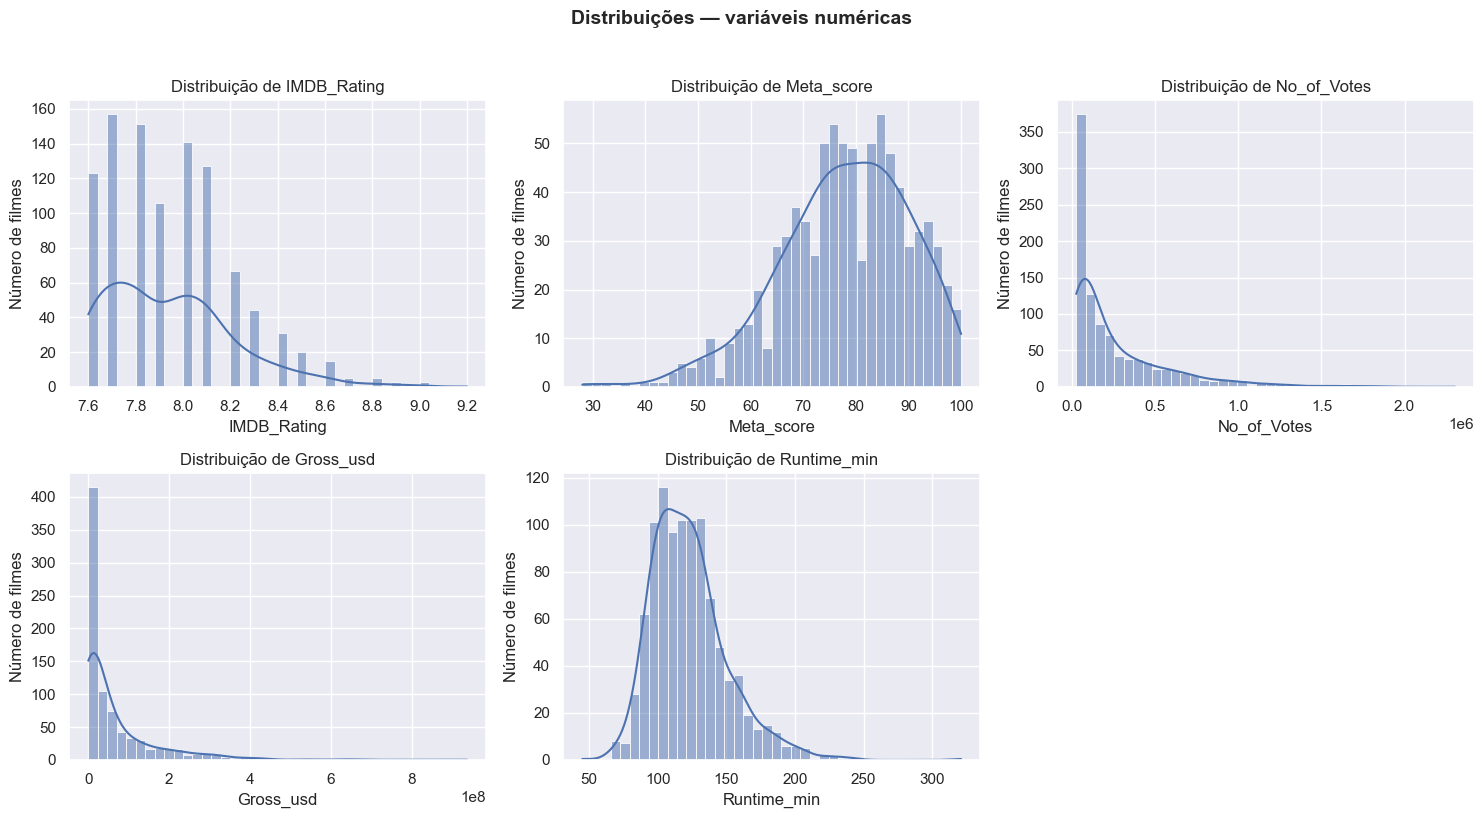

In [17]:
num_cols = ["IMDB_Rating", "Meta_score", "No_of_Votes", "Gross_usd", "Runtime_min"]

n = len(num_cols)
ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, bins=40, ax=axes[i])
    axes[i].set_title(f"Distribuição de {col}")
    axes[i].set_ylabel("Número de filmes")

for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes[j])

fig.suptitle("Distribuições — variáveis numéricas", fontsize=14, weight="bold", y=1.02)
plt.tight_layout()
plt.show()

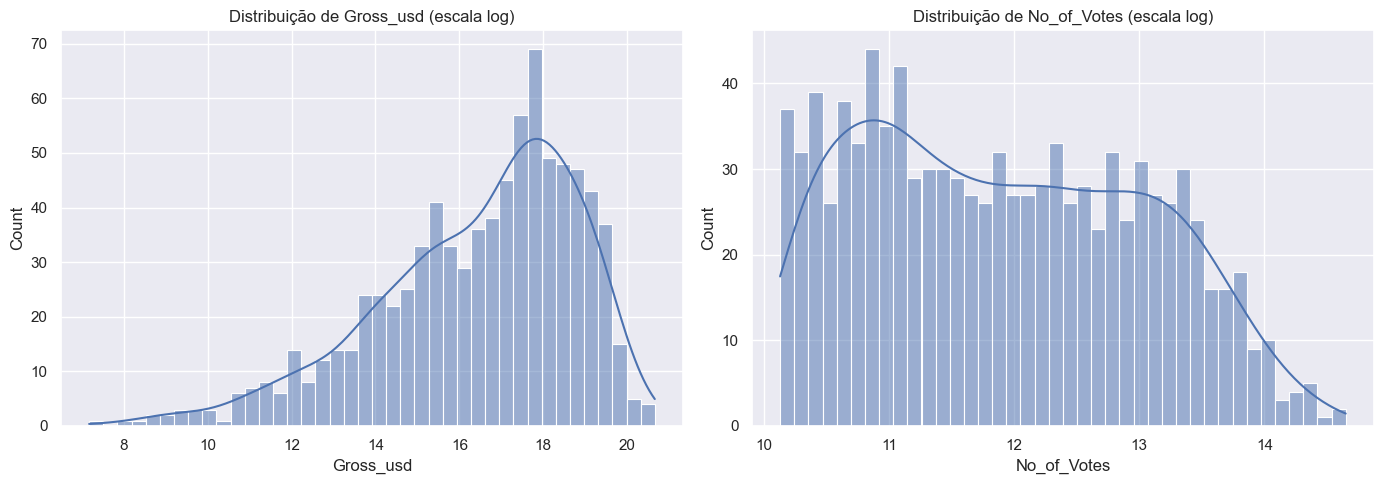

In [18]:
skewed = ["Gross_usd", "No_of_Votes"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for col, ax in zip(skewed, axes):
    sns.histplot(np.log1p(df[col].dropna()), bins=40, kde=True, ax=ax)
    ax.set_title(f"Distribuição de {col} (escala log)")

plt.tight_layout()
plt.show()

In [22]:
df[df["Runtime_min"] > 250][["Series_Title", "Runtime_min"]]

,Series_Title,Runtime_min
139,Gangs of Wasseypur,321.0


#### Análise univariada · Variáveis numéricas

##### IMDB_Rating
- **Distribuição**: concentrada entre **7.6–9.2** (média **≈ 7.95**, desvio **≈ 0.27**), com cauda curta à direita.  
- **Quartis**: P25 **7.7**, mediana **7.9**, P75 **8.1** → intervalo **estreito**.  
- **Leitura**: a amostra reúne **filmes já bem avaliados**, o que reduz a variância e o poder discriminatório dessa variável isoladamente.  
- **Implicação para modelagem**: vale combiná-la com outras fontes de variabilidade (ex.: `Meta_score`, texto de `Overview`) e evitar métricas muito sensíveis a pequenas diferenças.

---

##### Meta_score
- **Cobertura**: **842** valores (≈ **84.3%** do total) → **~15.7% faltantes**.  
- **Distribuição**: mais ampla que a de `IMDB_Rating` (**28–100**; média **≈ 78.0**; desvio **≈ 12.4**).  
- **Quartis**: P25 **70**, mediana **79**, P75 **87** → crítica **mais dispersa** que o público.  
- **Implicação**: boa candidata para **explicar variação** de qualidade; precisará de **estratégia de imputação** (ou modelo que lide com `NaN`).

---

##### No_of_Votes
- **Distribuição**: **fortemente assimétrica à direita**; média **≈ 272k** e mediana **≈ 138k**, máx **≈ 2.3M**.  
- **Quartis**: P25 **≈ 55k**, P75 **≈ 373k**.  
- **Escala log**: em `log(1 + votos)` a distribuição fica **mais próxima de normal**, reduzindo influência de outliers.  
- **Implicação**: usar **`log1p(No_of_Votes)`** em análises e modelos; considerar métricas robustas (mediana/IQR).

---

##### Gross_usd
- **Distribuição**: **cauda longa** (muitos filmes com faturamento baixo e poucos blockbusters acima de **US$ 500M–900M**).  
- **Escala log**: `log(1 + Gross_usd)` aproxima-se de **forma quase gaussiana**, facilitando correlações e regressões.  
- **Dados ausentes**: ~**16.9%** (conforme diagnóstico anterior) → requer **imputação** ou exclusão controlada dependendo do objetivo.  
- **Implicação**: para análises associativas/explicativas de receita, preferir **`log(Gross_usd)`**; avaliar **winsorization** dos extremos.

---

##### Runtime_min
- **Distribuição**: aproximadamente unimodal, centrada **~120–125 min**; variância moderada.  
- **Outliers**: casos acima de **250–300 min**; destaque para *Gangs of Wasseypur* (**321 min**).  
- **Implicação**: variável **estável**; pode entrar bruta. Se necessário, **cap** (ex.: P99) para mitigar raros outliers.

---

##### Conclusões rápidas (numéricas)
- `IMDB_Rating` tem **baixa dispersão**; `Meta_score` traz **variação útil** (cuidar dos **NaNs**).  
- `No_of_Votes` e `Gross_usd` exibem **caudas longas** → usar **transformação logarítmica** (`log1p`).  
- `Runtime_min` é **estável** e possui poucos outliers.  
- Para descrições e testes, prefira **medianas** e **IQR** em vez de médias quando houver assimetria marcada.

### 2.2 Variáveis Categóricas
Distribuição das variáveis qualitativas (Genre, Certificate, Director, elenco).

In [24]:
cat_cols = ["Certificate", "Genre", "Director", "Star1", "Star2", "Star3", "Star4"]

cat_summary = pd.DataFrame(
    {
        "n_unique": [df[col].nunique() for col in cat_cols],
        "most_common": [
            df[col].mode()[0] if not df[col].mode().empty else None for col in cat_cols
        ],
        "most_common_freq": [
            df[col].value_counts().iloc[0] if not df[col].value_counts().empty else None
            for col in cat_cols
        ],
        "missing": [df[col].isna().sum() for col in cat_cols],
    },
    index=cat_cols,
)

cat_summary

,n_unique,most_common,most_common_freq,missing
Certificate,16,U,234,101
Genre,202,Drama,84,0
Director,548,Alfred Hitchcock,14,0
Star1,659,Tom Hanks,12,0
Star2,840,Emma Watson,7,0
Star3,890,Rupert Grint,5,0
Star4,938,Michael Caine,4,0


In [62]:
top_certificate = df["Certificate"].value_counts().head(10)

top_director = df["Director"].value_counts().head(10)

genre_counts = (
    df["Genre"].str.get_dummies(sep=", ").sum().sort_values(ascending=False).head(10)
)

stars_long = pd.concat(
    [df["Star1"], df["Star2"], df["Star3"], df["Star4"]], ignore_index=True
)
top_stars = stars_long.value_counts().head(10)

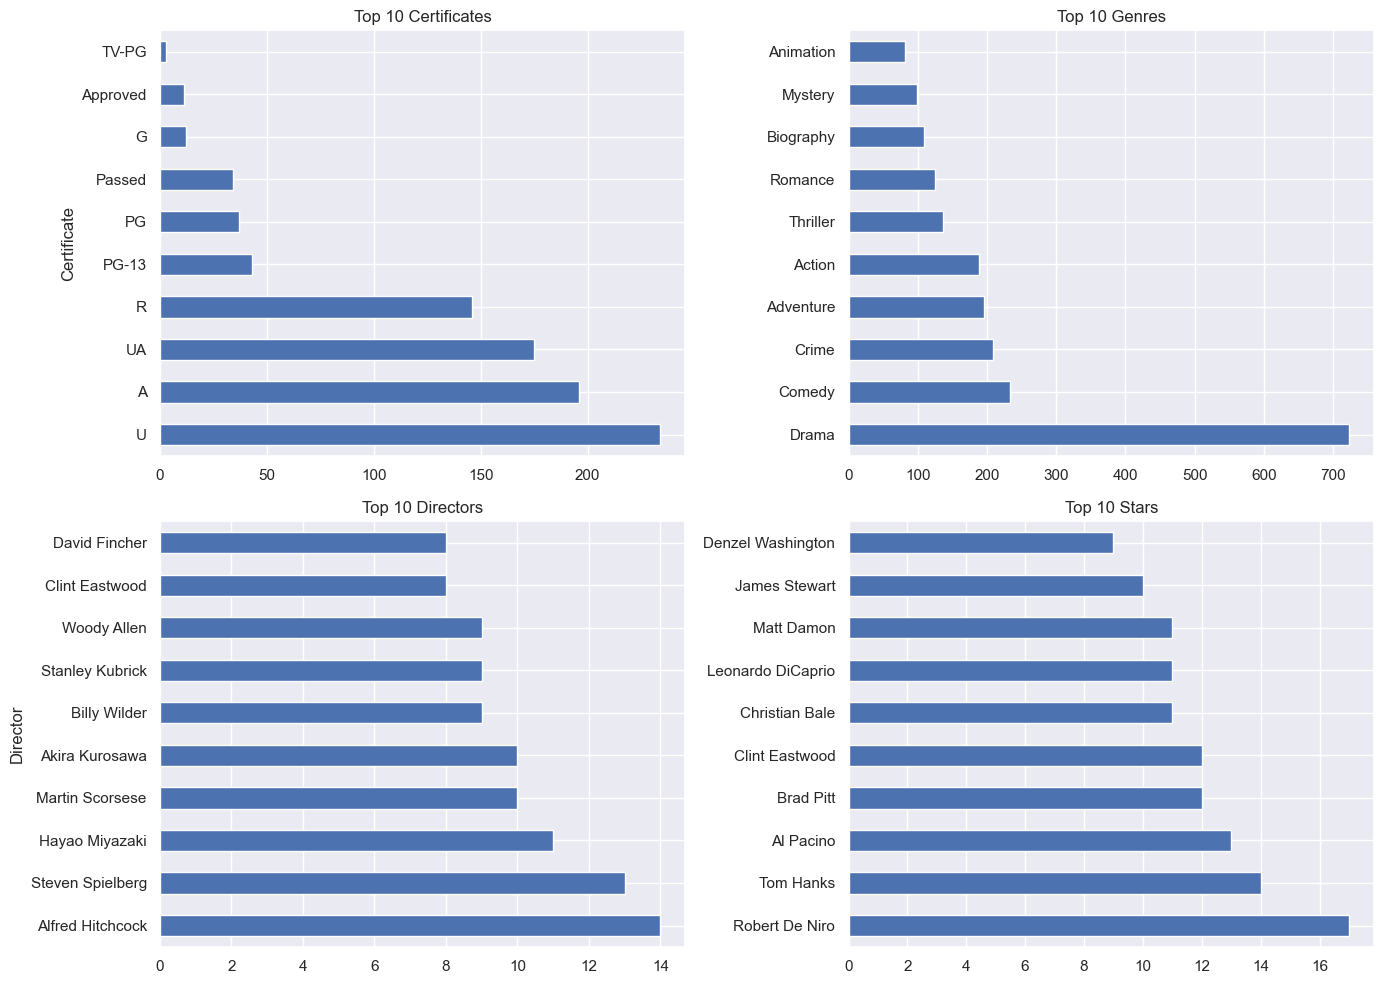

In [61]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

df["Certificate"].value_counts().head(10).plot(
    kind="barh", ax=axes[0, 0], title="Top 10 Certificates"
)

df["Genre"].str.get_dummies(sep=", ").sum().sort_values(ascending=False).head(10).plot(
    kind="barh", ax=axes[0, 1], title="Top 10 Genres"
)

df["Director"].value_counts().head(10).plot(
    kind="barh", ax=axes[1, 0], title="Top 10 Directors"
)

stars_long = pd.concat([df["Star1"], df["Star2"], df["Star3"], df["Star4"]])
stars_long.value_counts().head(10).plot(
    kind="barh", ax=axes[1, 1], title="Top 10 Stars"
)

plt.tight_layout()
plt.show()

#### Análise univariada · Variáveis categóricas

##### Certificate
- Forte concentração em poucas categorias dominantes.  
- Presença de valores ausentes (~10%), que precisarão de tratamento.  
- Filmes para todos os públicos aparecem de forma majoritária, o que pode enviesar comparações.  
- **Gráfico**: confirma que `U`, `A` e `UA` concentram a maior parte dos filmes, enquanto categorias como `G`, `PG` e `PG-13` aparecem em menor escala.

---

##### Genre
- Cardinalidade muito alta, com centenas de combinações de gêneros.  
- Gêneros populares como Drama dominam a amostra.  
- Necessário tratamento específico (*multi-label encoding* ou redução de dimensionalidade).  
- **Gráfico**: reforça que **Drama** é disparado o gênero mais frequente, seguido de **Comedy** e **Crime**, enquanto gêneros como **Animation** e **Mystery** têm representatividade bem menor.

---

##### Director
- Elevada dispersão: a maioria aparece apenas em 1 filme.  
- Alguns nomes de destaque (ex.: Hitchcock, Spielberg) concentram mais títulos.  
- Recomendável filtrar por número mínimo de filmes para análises.  
- **Gráfico**: mostra Hitchcock e Spielberg no topo (14 filmes cada), seguidos por nomes clássicos como Scorsese, Kubrick e Clint Eastwood, refletindo **diretores de longa carreira ou grande relevância histórica**.

---

##### Stars (1–4)
- Alta cardinalidade, refletindo diversidade de atores.  
- Poucos nomes se repetem com frequência, ligados a franquias de sucesso.  
- Ideal consolidar em formato longo para análise agregada (ex.: bilheteria média por ator).  
- **Gráfico**: evidencia **Robert De Niro** e **Tom Hanks** como os mais recorrentes (~15 filmes cada), seguidos de Al Pacino, Brad Pitt e Clint Eastwood, todos atores de renome internacional.  

---

##### Conclusões (categóricas)
- **Certificate**: precisa de imputação de nulos e atenção ao viés dos filmes “para todos os públicos”.  
- **Genre**: requer técnicas para lidar com múltiplos gêneros e elevada cardinalidade.  
- **Director/Stars**: muito dispersos; análises mais úteis quando filtrados ou consolidados.  
- Os **gráficos Top 10** ajudam a identificar rapidamente os nomes e categorias dominantes, facilitando a seleção de variáveis para modelagem ou geração de recomendações.  

## 3. Análise Temporal

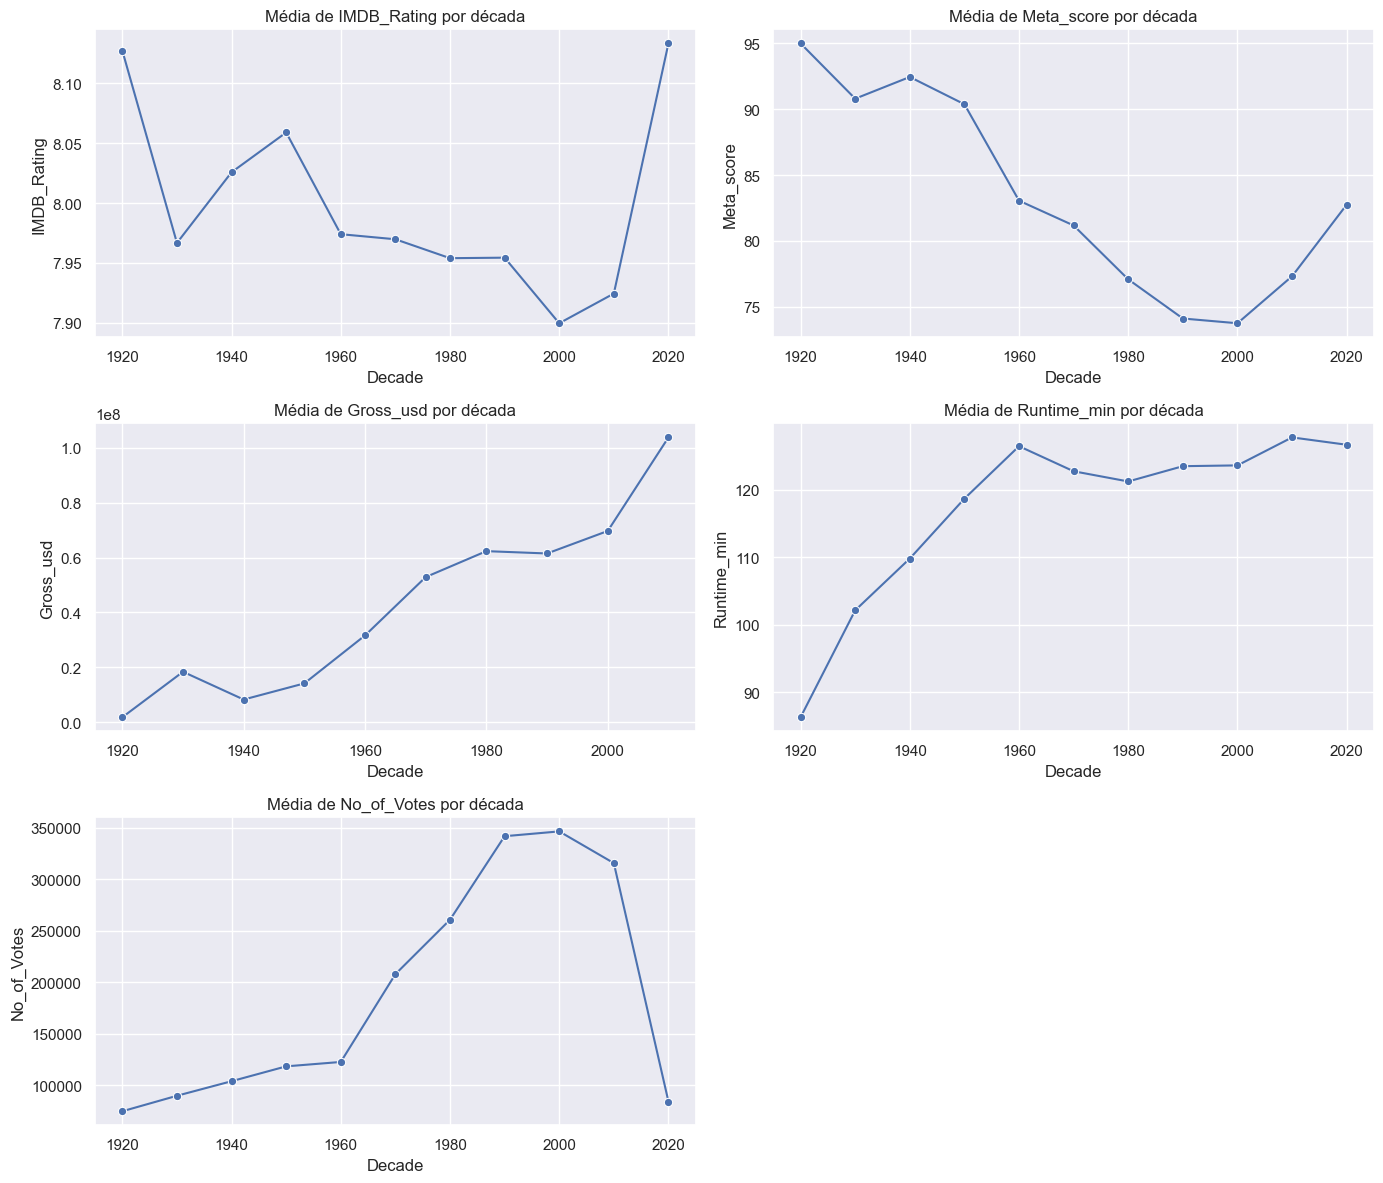

In [50]:
df["Released_Year"] = pd.to_numeric(df["Released_Year"], errors="coerce")
df["Decade"] = (df["Released_Year"] // 10) * 10

agg_cols = ["IMDB_Rating", "Meta_score", "Gross_usd", "Runtime_min", "No_of_Votes"]

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

for i, col in enumerate(agg_cols):
    sns.lineplot(
        data=df, x="Decade", y=col, estimator="mean", ci=None, marker="o", ax=axes[i]
    )
    axes[i].set_title(f"Média de {col} por década")

for j in range(len(agg_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [51]:
decade_stats = (
    df.dropna(subset=["Decade"])
    .groupby("Decade")
    .agg(
        n=("Decade", "size"),
        gross_med=("Gross_usd", "median"),
        votes_med=("No_of_Votes", "median"),
        rating_med=("IMDB_Rating", "median"),
        meta_med=("Meta_score", "median"),
        runtime_med=("Runtime_min", "median"),
    )
    .sort_index()
)
decade_stats

,n,gross_med,votes_med,rating_med,meta_med,runtime_med
Decade,,,,,,
1920.0,11,1005635.0,57428.0,8.1,97.0,76.0
1930.0,24,3270000.0,53508.0,7.9,91.5,96.0
1940.0,35,3505000.0,59556.0,8.0,95.5,106.0
1950.0,56,8000000.0,78315.5,8.0,91.0,111.0
1960.0,73,16217773.0,69458.0,8.0,86.0,120.0
1970.0,76,31800000.0,95219.5,7.9,83.0,120.5
1980.0,89,39242020.5,166588.0,7.9,78.0,116.0
1990.0,149,25010410.0,171640.0,7.9,75.0,119.0
2000.0,237,23637265.0,236311.0,7.8,76.0,121.0


#### Análise Temporal

##### **IMDB_Rating**
- Mantém-se relativamente estável (7.8–8.1), com pico nos anos 1920 e recuperação nos anos 2020.  
- O intervalo estreito sugere consistência na avaliação média do público.

---

##### **Meta_score**
- Apresenta trajetória de queda desde os anos 1950 (≈ 91) até os anos 2000 (≈ 76).  
- Indica que a crítica se tornou mais exigente ou que o perfil de filmes populares mudou.

---

##### **Gross_usd (bilheteria)**
- Forte crescimento até os anos 2010, atingindo medianas superiores a **100 milhões**.  
- Reflexo da globalização e dos blockbusters, especialmente no cinema de franquias.  
- Década de 2020 tem dados insuficientes (poucos filmes e sem mediana confiável).

---

##### **No_of_Votes**
- Crescimento marcante a partir de 1980, com explosão nos anos 2000 (mediana ≈ 236k).  
- Relação direta com a popularização da internet e plataformas como o IMDb.  
- Década de 2020 aparece artificialmente baixa pela quantidade reduzida de títulos.

---

#### **Runtime_min**
- Aumentou até os anos 1960 (~120 min), depois estabilizou entre **120–126 min**.  
- Reflete o padrão de longas-metragens comerciais, com pouca variação estrutural.  
- Outliers pontuais (ex.: filmes épicos) não alteram a tendência.

---

##### **Principais insights temporais**
1. **Crescimento estrutural**: bilheteria e votos aumentaram ao longo do século, sinalizando expansão do mercado e da audiência.  
2. **Crítica mais rigorosa**: queda do `Meta_score` contrasta com a estabilidade do `IMDB_Rating`.  
3. **Padrão narrativo estável**: duração média se manteve próxima a 2 horas após os anos 1960.  
4. **Década de 2020**: deve ser interpretada com cautela, pois a amostra é muito pequena (n = 6 filmes).

## 5. Análise Multivariada

<Axes: >

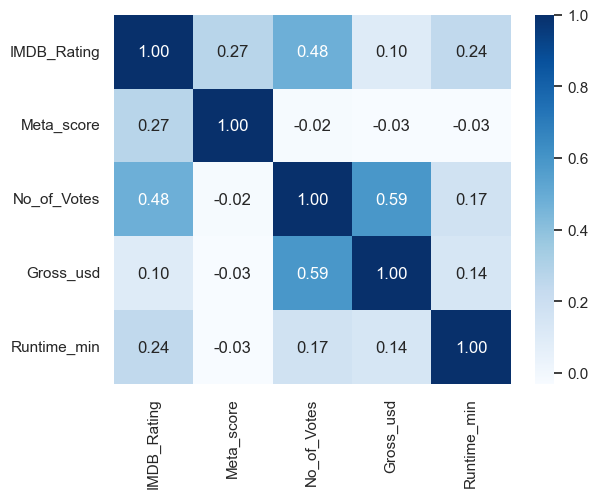

In [ ]:
corr = df[
    ["IMDB_Rating", "Meta_score", "No_of_Votes", "Gross_usd", "Runtime_min"]
].corr()
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")

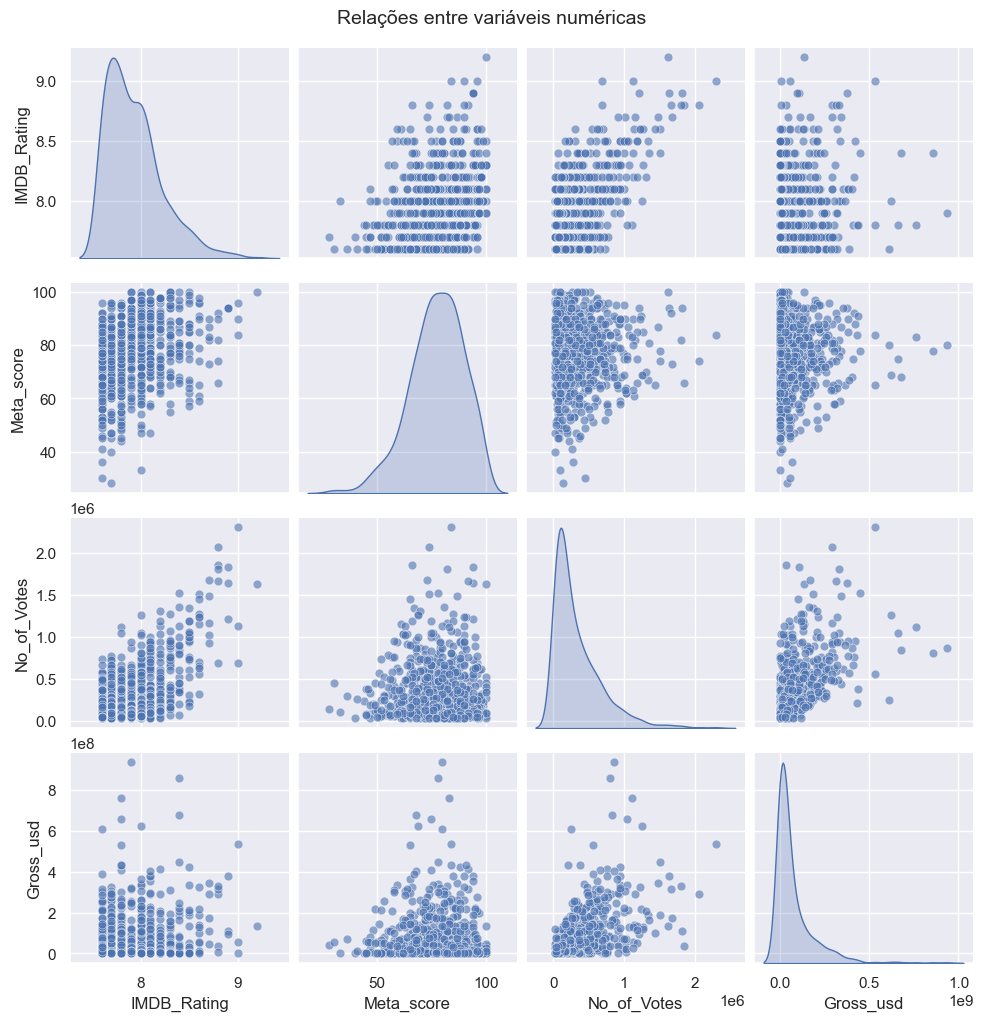

In [ ]:
num_cols_focus = ["IMDB_Rating", "Meta_score", "No_of_Votes", "Gross_usd"]

sns.pairplot(
    df[num_cols_focus].dropna(),
    diag_kind="kde",
    plot_kws={"alpha": 0.6, "s": 40, "edgecolor": "w"},
    height=2.5,
)

plt.suptitle("Relações entre variáveis numéricas", y=1.02, fontsize=14)
plt.show()

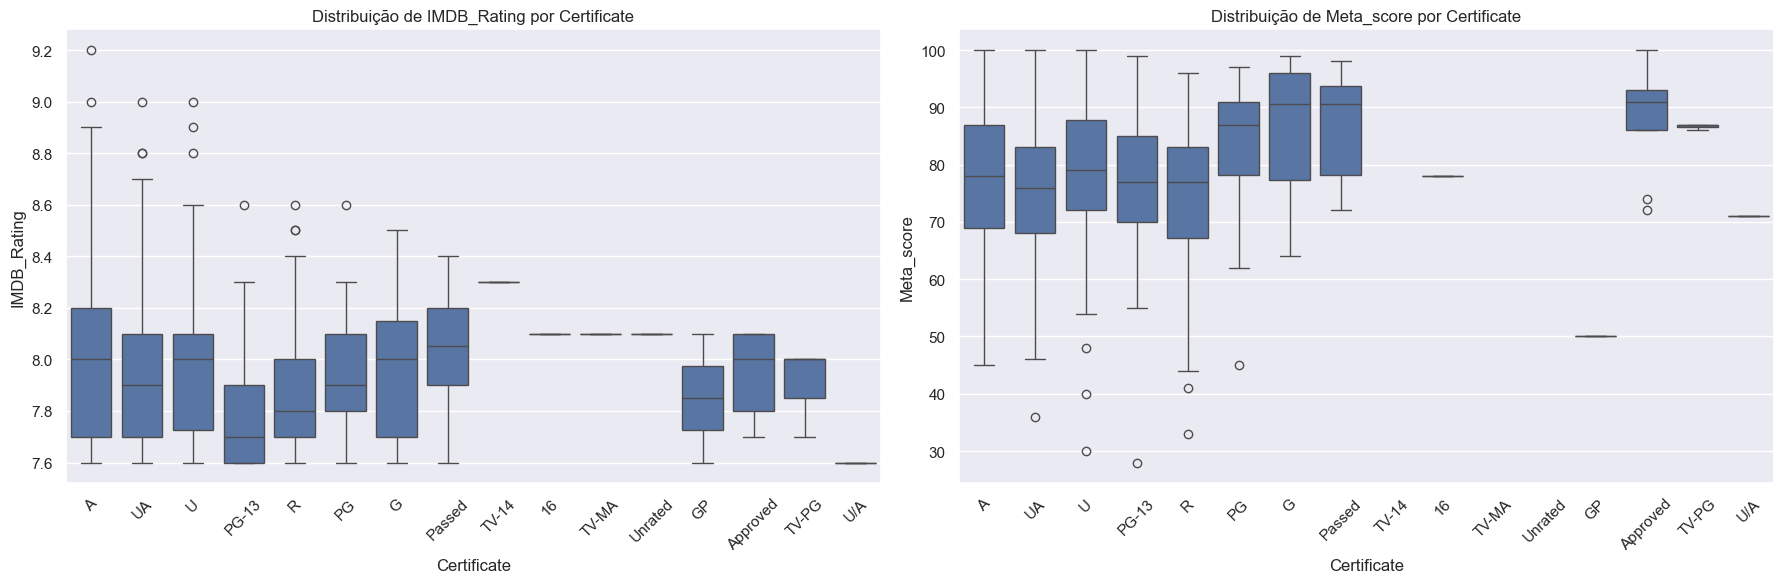

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.boxplot(data=df, x="Certificate", y="IMDB_Rating", ax=axes[0])
axes[0].set_title("Distribuição de IMDB_Rating por Certificate", fontsize=12)
axes[0].tick_params(axis="x", rotation=45)

sns.boxplot(data=df, x="Certificate", y="Meta_score", ax=axes[1])
axes[1].set_title("Distribuição de Meta_score por Certificate", fontsize=12)
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [64]:
for c in ["Gross_usd", "No_of_Votes", "Meta_score", "IMDB_Rating", "Runtime_min"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df["Released_Year"] = pd.to_numeric(df["Released_Year"], errors="coerce")
df["Decade"] = (df["Released_Year"] // 10) * 10

df_gen = (
    df.assign(Genre=df["Genre"].str.split(", "))
    .explode("Genre")
    .dropna(subset=["Genre"])
    .copy()
)

stars_long = pd.concat(
    [df["Star1"], df["Star2"], df["Star3"], df["Star4"]], ignore_index=True
)
stars_long.name = "Star"
df_stars = df.assign(Star=None).drop(columns=["Star1", "Star2", "Star3", "Star4"])
df_stars = pd.concat(
    [
        df_stars.reset_index(drop=True).loc[df.index.repeat(4)].reset_index(drop=True),
        stars_long,
    ],
    axis=1,
).dropna(subset=["Star"])

In [ ]:
min_count = 15
genre_stats = (
    df_gen.groupby("Genre")
    .agg(
        n=("Genre", "size"),
        gross_med=("Gross_usd", "median"),
        gross_q75=("Gross_usd", lambda x: np.nanpercentile(x, 75)),
        votes_med=("No_of_Votes", "median"),
        rating_med=("IMDB_Rating", "median"),
        meta_med=("Meta_score", "median"),
    )
    .query("n >= @min_count")
    .sort_values("gross_med", ascending=False)
)
genre_stats.head(15)

,n,gross_med,gross_q75,votes_med,rating_med,meta_med
Genre,,,,,,
Adventure,196,120580486.5,2.594166e+08,302404.5,7.90,79.5
Animation,82,75082668.0,2.207477e+08,169246.0,7.90,82.0
Sci-Fi,67,70511035.0,2.262771e+08,556608.0,7.90,77.0
Action,189,65707655.0,2.182257e+08,253228.0,7.90,74.5
Family,56,46061332.5,1.347780e+08,167652.0,7.80,78.0
Fantasy,66,45953122.5,1.573429e+08,254132.0,7.90,78.5
History,56,43984230.0,7.145688e+07,109503.5,7.95,77.5
Biography,109,39808740.5,7.539870e+07,159886.0,7.90,76.0
Thriller,137,25782912.0,7.654154e+07,186734.0,7.90,78.0


In [ ]:
cert_stats = (
    df.groupby("Certificate")
    .agg(
        n=("Certificate", "size"),
        imdb_med=("IMDB_Rating", "median"),
        meta_med=("Meta_score", "median"),
        gross_med=("Gross_usd", "median"),
        votes_med=("No_of_Votes", "median"),
    )
    .sort_values(["imdb_med", "meta_med"], ascending=False)
)
cert_stats

,n,imdb_med,meta_med,gross_med,votes_med
Certificate,,,,,
TV-14,1,8.30,NaN,NaN,33935.0
16,1,8.10,78.0,NaN,47708.0
TV-MA,1,8.10,NaN,NaN,141516.0
Unrated,1,8.10,NaN,300000.0,66803.0
Passed,34,8.05,90.5,4360000.0,55734.0
Approved,11,8.00,91.0,4360000.0,57259.0
G,12,8.00,90.5,33190753.5,70401.5
TV-PG,3,8.00,87.0,106662.0,30683.0
U,234,8.00,79.0,40155347.0,151897.5


In [ ]:
min_films = 3
director_stats = (
    df.groupby("Director")
    .agg(
        n=("Director", "size"),
        gross_med=("Gross_usd", "median"),
        votes_med=("No_of_Votes", "median"),
        imdb_med=("IMDB_Rating", "median"),
        meta_med=("Meta_score", "median"),
    )
    .query("n >= @min_films")
    .sort_values("gross_med", ascending=False)
)
director_stats.head(15)

,n,gross_med,votes_med,imdb_med,meta_med
Director,,,,,
Anthony Russo,4,543449915.5,773068.5,8.10,72.5
Peter Jackson,5,315544750.0,1485555.0,8.70,87.0
David Yates,3,301959197.0,479120.0,7.70,78.0
Pete Docter,4,293004164.0,715866.5,8.10,85.5
J.J. Abrams,3,257730019.0,577336.0,7.90,80.0
Brad Bird,4,233943373.0,445851.0,8.00,87.5
Ron Clements,3,217350219.0,272784.0,7.60,86.0
Bryan Singer,3,216428042.0,659763.0,8.00,75.0
Robert Zemeckis,5,210609762.0,524235.0,7.80,82.0


In [ ]:
for c in ["Gross_usd", "No_of_Votes", "IMDB_Rating", "Meta_score"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

star_cols = ["Star1", "Star2", "Star3", "Star4"]
df_stars = (
    df[
        ["Series_Title", "Gross_usd", "No_of_Votes", "IMDB_Rating", "Meta_score"]
        + star_cols
    ]
    .melt(
        id_vars=[
            "Series_Title",
            "Gross_usd",
            "No_of_Votes",
            "IMDB_Rating",
            "Meta_score",
        ],
        value_vars=star_cols,
        var_name="star_slot",
        value_name="Star",
    )
    .dropna(subset=["Star"])
)
min_films_star = 5
star_stats = (
    df_stars.groupby("Star", as_index=True)
    .agg(
        n=("Star", "size"),
        gross_med=("Gross_usd", "median"),
        votes_med=("No_of_Votes", "median"),
        imdb_med=("IMDB_Rating", "median"),
        meta_med=("Meta_score", "median"),
    )
    .query("n >= @min_films_star")
    .sort_values("gross_med", ascending=False)
)

star_stats.head(20)

,n,gross_med,votes_med,imdb_med,meta_med
Star,,,,,
Robert Downey Jr.,7,408084349.0,809955.0,7.90,75.0
Chris Evans,6,333925460.5,699915.5,7.85,72.5
Ian McKellen,7,303003568.0,757377.0,7.90,75.0
Daniel Radcliffe,6,298971251.0,550556.0,7.70,79.5
Rupert Grint,6,298971251.0,550556.0,7.70,79.5
Emma Watson,7,290013036.0,479120.0,7.80,81.0
Harrison Ford,8,222665888.5,788969.5,8.25,83.0
Mark Ruffalo,7,221535611.5,587775.0,8.10,74.0
Tom Hardy,5,183637894.0,705589.0,8.10,78.0


In [ ]:
df["Gross_log"] = np.log1p(df["Gross_usd"])
df["Votes_log"] = np.log1p(df["No_of_Votes"])

genre_stats_log = (
    df_gen.assign(
        Gross_log=np.log1p(df_gen["Gross_usd"]),
        Votes_log=np.log1p(df_gen["No_of_Votes"]),
    )
    .groupby("Genre")
    .agg(
        n=("Genre", "size"),
        gross_log_med=("Gross_log", "median"),
        votes_log_med=("Votes_log", "median"),
    )
    .query("n >= @min_count")
    .sort_values("gross_log_med", ascending=False)
)
genre_stats_log.head(15)

,n,gross_log_med,votes_log_med
Genre,,,
Adventure,196,18.607828,12.619468
Animation,82,18.134100,12.038974
Sci-Fi,67,18.071280,13.229618
Action,189,18.000697,12.442049
Family,56,17.637987,12.029624
Fantasy,66,17.634289,12.445607
History,56,17.599342,11.602129
Biography,109,17.498202,11.982223
Thriller,137,17.065180,12.137446


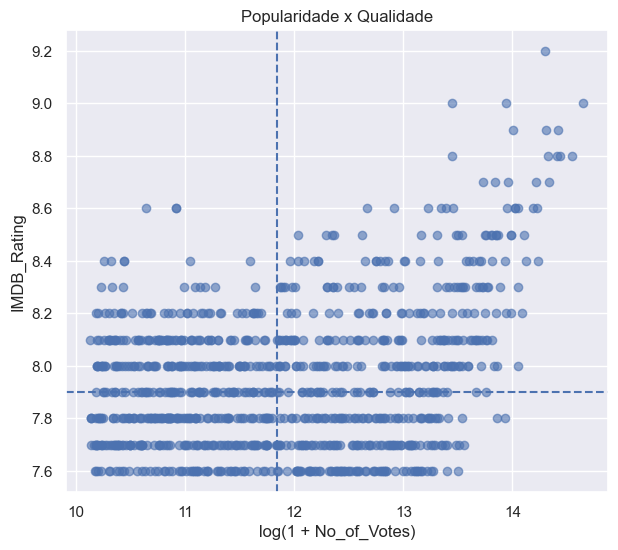

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(np.log1p(df["No_of_Votes"]), df["IMDB_Rating"], alpha=0.6)
ax.set(
    xlabel="log(1 + No_of_Votes)",
    ylabel="IMDB_Rating",
    title="Popularidade x Qualidade",
)

xmed, ymed = np.log1p(df["No_of_Votes"]).median(), df["IMDB_Rating"].median()
ax.axvline(xmed, ls="--")
ax.axhline(ymed, ls="--")
plt.show()

In [ ]:
genre_dum = df["Genre"].str.get_dummies(sep=", ")
genre_stats = pd.DataFrame(
    {
        "count": genre_dum.sum().astype(int),
        "mean_rating": (
            genre_dum.mul(df["IMDB_Rating"], axis=0).sum() / genre_dum.sum()
        ),
    }
).sort_values("count", ascending=False)
genre_stats.head(15)

,count,mean_rating
Drama,723,7.957538
Comedy,233,7.903433
Crime,209,7.954545
Adventure,196,7.952041
Action,189,7.948677
Thriller,137,7.909489
Romance,125,7.925600
Biography,109,7.935780
Mystery,99,7.967677
Animation,82,7.930488


In [63]:
# Cálculo do IMDb Weighted Rating (WR)

C = df["IMDB_Rating"].mean()  
m = 25000                     

qualified = df[df["No_of_Votes"] >= m].copy()

qualified["WR"] = (
    (qualified["No_of_Votes"] / (qualified["No_of_Votes"] + m)) * qualified["IMDB_Rating"]
    + (m / (qualified["No_of_Votes"] + m)) * C
)

top10_wr = qualified.sort_values("WR", ascending=False).head(10)
top10_wr[["Series_Title", "IMDB_Rating", "No_of_Votes", "WR"]]

,Series_Title,IMDB_Rating,No_of_Votes,WR
0,The Godfather,9.2,1620367,9.180976
1,The Dark Knight,9.0,2303232,8.988703
2,The Godfather: Part II,9.0,1129952,8.977227
3,12 Angry Men,9.0,689845,8.963207
5,Pulp Fiction,8.9,1826188,8.887143
4,The Lord of the Rings: The Return of the King,8.9,1642758,8.885729
6,Schindler's List,8.9,1213505,8.880782
7,Inception,8.8,2067042,8.789818
8,Fight Club,8.8,1854740,8.788668
10,Forrest Gump,8.8,1809221,8.788387


#### Análise Multivariada

##### Correlações
- `No_of_Votes` apresenta **forte correlação positiva** com `Gross_usd` (≈ 0.59) → filmes mais votados tendem a ter maior bilheteria.  
- `IMDB_Rating` correlaciona-se moderadamente com `No_of_Votes` (≈ 0.48) → popularidade e nota estão relacionadas, mas não de forma determinística.  
- `Meta_score` tem **baixa correlação** com as demais métricas → reforça que a crítica especializada segue padrões diferentes do público.  
- `Runtime_min` não mostra relação significativa com bilheteria ou votos.  

**Insight**: votos e receita caminham juntos, mas qualidade (nota da crítica e do público) segue lógicas mais autônomas.

---

##### Certificate x Notas
- Filmes **“para todos os públicos” (G, PG, U)** concentram **metascores mais altos** (≈ 85–90), sugerindo maior aprovação da crítica.  
- Filmes com classificação **R e PG-13** atraem muito público (mais votos, maior bilheteria), mas têm desempenho crítico relativamente menor.  
- Há variação significativa dentro das categorias, reforçando que a certificação é um **indicador parcial**, não determinante.  

**Insight**: existe uma divisão clara entre **qualidade crítica** (filmes familiares) e **popularidade comercial** (filmes adultos/restritos).

---

##### Gênero x Métricas
- **Adventure, Action, Sci-Fi e Animation** lideram em **bilheteria mediana**, refletindo seu apelo comercial global.  
- **Sci-Fi e Action** também concentram o maior número de votos → forte engajamento do público.  
- Em termos de **avaliação da crítica**, destacam-se `Animation`, `History` e `Western`.  
- As notas do público (IMDB_Rating) são muito próximas entre gêneros, variando pouco (~7.8–8.0).  

**Insight**: gêneros **comerciais** (Adventure, Sci-Fi, Action) garantem receita, enquanto gêneros de **prestígio** (History, Western) tendem a agradar mais à crítica.

---

##### Diretores e Estrelas
- **Diretores de franquias** (Anthony Russo, Peter Jackson, James Cameron, Nolan) apresentam altíssimas medianas de bilheteria, alavancadas por sagas como *Marvel*, *Senhor dos Anéis* e *Avatar*.  
- Entre os mais equilibrados (bilheteria + crítica): **Pete Docter** (Pixar) e **Peter Jackson** se destacam.  
- **Atores**:  
  - **Robert Downey Jr., Chris Evans, Ian McKellen** → dominam em bilheteria média, refletindo o impacto de universos compartilhados.  
  - **Tom Hanks, Leonardo DiCaprio, Matt Damon** → mantêm bom equilíbrio entre volume de filmes, popularidade e crítica.  

**Insight**: **franquias e estrelas recorrentes** são chave para grandes receitas, mas nomes clássicos mantêm consistência qualitativa.

---

##### Popularidade x Qualidade
- O gráfico `log(No_of_Votes)` vs `IMDB_Rating` mostra que:  
  - Filmes com **notas altíssimas (> 8.5)** não estão entre os mais votados → títulos cultuados ou clássicos de nicho.  
  - Filmes com **milhões de votos** tendem a ter notas medianas (7.8–8.3), raramente ultrapassando 9.0.  
- Isso reforça a **não linearidade** entre popularidade e qualidade.  

**Insight**: um sistema de recomendação robusto deve **combinar as duas dimensões**, evitando priorizar apenas “mais votados” ou “mais bem avaliados”.

---

##### Ranking Ponderado (WR)
- Aplicando o **IMDb Weighted Rating (WR)**, que combina nota e número de votos, os resultados são mais equilibrados:  
  - **The Godfather** lidera (WR ≈ 9.18).  
  - Sequências e clássicos cultuados ocupam posições altas: *The Dark Knight*, *The Godfather: Part II*, *Pulp Fiction*, *Schindler’s List*, *Fight Club*.  
  - O método corrige distorções, evitando que filmes pouco votados com nota altíssima dominem o ranking.  

**Insight**: o WR é uma métrica mais robusta para comparações, pois captura tanto a **nota média** quanto a **popularidade relativa**.

---

**Conclusão da Multivariada**  
Os padrões revelam um **trade-off constante**:  
- Gêneros comerciais e franquias garantem bilheteria e votos.  
- Gêneros familiares tendem a agradar à crítica.  
- Filmes cultuados preservam notas altas, mas não atraem milhões de votos.  
- O **WR** aparece como uma síntese confiável para ranqueamento.  


## 6. Overview (texto)

Valores ausentes em Overview: 0.0%


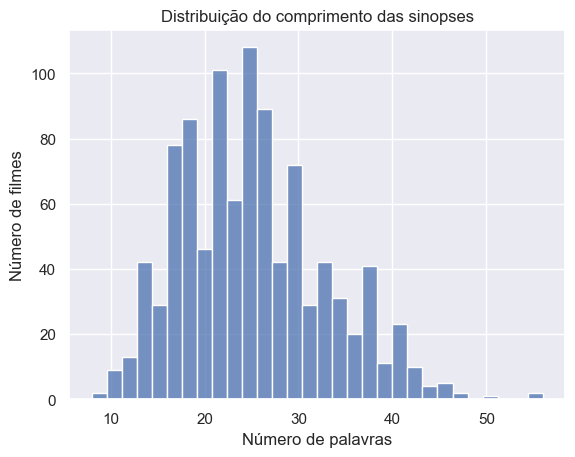

In [71]:
missing_pct = df["Overview"].isna().mean() * 100
print(f"Valores ausentes em Overview: {missing_pct:.1f}%")

df["overview_len"] = df["Overview"].dropna().astype(str).str.split().apply(len)

sns.histplot(df["overview_len"], bins=30, kde=False)
plt.title("Distribuição do comprimento das sinopses")
plt.xlabel("Número de palavras")
plt.ylabel("Número de filmes")
plt.show()

In [80]:
words = " ".join(df["Overview"].dropna().str.lower()).split()
words = [w for w in words if w not in ENGLISH_STOP_WORDS]

word_counts = Counter(words).most_common(20)
word_df = pd.DataFrame(word_counts, columns=["Palavra", "Frequência"])

print("Top 20 palavras mais frequentes nas sinopses")
display(word_df)

Top 20 palavras mais frequentes nas sinopses


,Palavra,Frequência
0,young,131
1,man,100
2,life,74
3,new,71
4,world,60
5,story,59
6,war,54
7,woman,51
8,love,47
9,finds,47


#### Overview — Análise exploratória

##### Comprimento das sinopses
- A maioria das sinopses concentra-se entre **15 e 35 palavras**.  
- O pico da distribuição ocorre próximo a **25 palavras**, sugerindo certa padronização no tamanho.  
- Existem poucos casos acima de 45 palavras, mostrando que sinopses muito longas são raras.  

---

##### Palavras mais frequentes
- Entre as 20 palavras mais comuns, destacam-se: **young, man, life, new, world, story, war, woman, love, finds**.  
- Nota-se forte presença de termos relacionados a **pessoas** (*man, woman, boy, girl, father, family, friends*).  
- Também aparecem palavras ligadas a **temas recorrentes** em narrativas (*life, world, war, love, story*).  

---

##### Conclusão (Overview)
- As sinopses possuem um tamanho relativamente consistente, em torno de 25 palavras.  
- O vocabulário mais frequente está associado a personagens e temas universais, confirmando a repetição de padrões narrativos no conjunto.  

## 7. Considerações finais

A análise exploratória permitiu identificar padrões importantes na base de filmes:

- **Qualidade dos dados**:  
  Estrutura consistente, mas com variáveis numéricas mal tipadas (`Gross`, `Runtime`) e proporção relevante de nulos em `Meta_score`, `Gross` e `Certificate`.  

- **Univariada**:  
  - `IMDB_Rating` tem baixa dispersão (7.6–9.2), reduzindo seu poder discriminatório isolado.  
  - `Meta_score` apresenta maior variabilidade e pode agregar explicação.  
  - `No_of_Votes` e `Gross_usd` exibem caudas longas → requerem transformação logarítmica.  
  - `Runtime_min` é estável, com poucos outliers.  

- **Categóricas**:  
  - Forte concentração em poucos gêneros (*Drama* domina).  
  - Alta dispersão em diretores e estrelas → análises só fazem sentido com filtragem mínima.  
  - Certificados revelam viés (muitos filmes para todos os públicos), com ~10% de valores ausentes.  

- **Temporal**:  
  - Bilheteria e votos cresceram estruturalmente ao longo do século.  
  - `Meta_score` caiu com o tempo, sugerindo crítica mais rigorosa.  
  - Duração estabilizada em torno de 120 minutos desde os anos 1960.  

- **Multivariada**:  
  - Correlação forte entre votos e bilheteria, mas fraca entre crítica e público.  
  - Certificados familiares têm notas mais altas na crítica, enquanto restritivos atraem mais público.  
  - Gêneros de ação, aventura e sci-fi concentram bilheteria; history e western agradam mais à crítica.  
  - O IMDb Weighted Rating (WR) combina popularidade e nota, equilibrando distorções e produzindo um ranking robusto.  

- **Overview (texto)**:  
  - Sinopses têm comprimento consistente (~25 palavras).  
  - Vocabulário mais frequente reforça foco em personagens e temas universais (*man, woman, life, war, love*).  

---

### Próximos passos
1. **Overview (texto)** — será aprofundado em notebook específico (`02_overview_nlp.ipynb`), com pré-processamento, TF-IDF/embeddings e classificação de gêneros.  

2. **Pré-processamento**:  
   - Tratar nulos (`Meta_score`, `Gross`, `Certificate`).  
   - Converter variáveis numéricas e aplicar `log1p` em `No_of_Votes` e `Gross_usd`.  
   - Normalizar gêneros (multi-label encoding).  

3. **Modelagem**:  
   - Regressão para prever `IMDB_Rating` a partir de variáveis numéricas, categóricas e texto (`Overview`).  
   - Avaliar uso de embeddings ou TF-IDF.  
   - Métrica sugerida: **RMSE**.  

4. **Produto final**:  
   - Recomendações de investimento em gêneros/diretores/atores com maior potencial de retorno.  
   - Sistema de ranqueamento baseado em WR para equilibrar popularidade e qualidade.  
